# Now that we have all the Data ready we can begin our Analysis.

## Inspecting the DataSet

In [129]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency, boxcox, yeojohnson

In [130]:
PERCENTAGE = 0.01

file_path = f'..\\resources\\toxicity_analysis_{PERCENTAGE:.0%}_data.tsv'

try:
    toxicity_analysis_df = pd.read_csv(file_path, sep="\t")  
except Exception as e:
    print(f"Error loading file: {e}")

In [131]:
toxicity_analysis_df

,subreddit_category,word_count,preprocessed,toxicity_label
0,Advice,228,"i 'm 23 , moved back in with parents . how do ...",0
1,Advice,143,always feel an overwhelming lack of confidence...,0
2,Advice,233,"dealing with this break up hey there , this mo...",0
3,Advice,398,disagreement when picking rooms in the new hou...,0
4,Advice,226,i do n't know what i believe i do n't typicall...,0
...,...,...,...,...
1144,travel,213,"traveling , a few questions , ( planning a tri...",0
1145,weddingplanning,280,"wedding blanket ? i 'm a plus size bride , wit...",0
1146,weddingplanning,336,"36 days to go , & i ca n't find my english bir...",0
1147,weddingplanning,301,making your own wedding invitations ... is it ...,0


C:\Users\sinaj\AppData\Local\Temp\ipykernel_5620\1579856165.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_counts, x='toxicity_label', y='percentage', palette=['skyblue', 'salmon'])


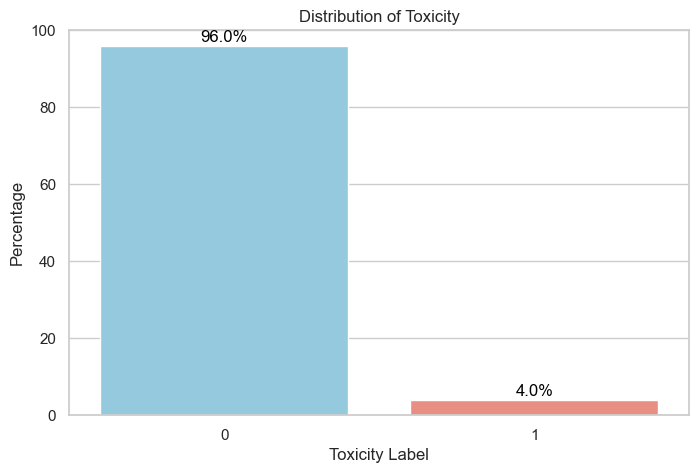

In [132]:
# Calculation of the proportions
category_counts = toxicity_analysis_df.groupby('toxicity_label').size().reset_index(name='count')

# Calculate the total for the procentual proportions
total_counts = category_counts['count'].sum()
category_counts['percentage'] = (category_counts['count'] / total_counts) * 100

# Plot the data 
plt.figure(figsize=(8, 5))
sns.barplot(data=category_counts, x='toxicity_label', y='percentage', palette=['skyblue', 'salmon'])
plt.title('Distribution of Toxicity')
plt.ylabel('Percentage')
plt.xlabel('Toxicity Label')
plt.ylim(0, 100)  

for index, row in category_counts.iterrows():
    plt.text(index, row['percentage'] + 1, f"{row['percentage']:.1f}%", color='black', ha='center')

plt.show()


We could assume that 96% of the reddit comments are non-toxic.

# Hypothesis: There are significant differences in toxicity between the different subreddit categories.
# Null-Hypothesis: There are no significant differences in toxicity between the different subreddit categories.

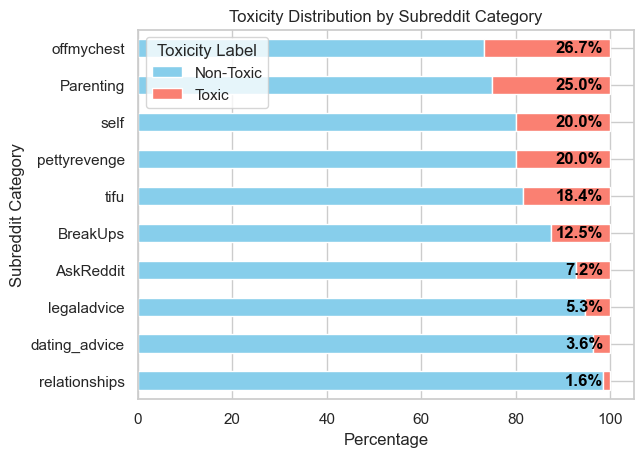

In [133]:
# Include only categories with at least one toxic post
toxic_categories = toxicity_analysis_df[toxicity_analysis_df['toxicity_label'] == 1]['subreddit_category'].unique()
toxic_only_df = toxicity_analysis_df[toxicity_analysis_df['subreddit_category'].isin(toxic_categories)]

# Calculate toxicity percentages by category
category_counts = toxic_only_df.groupby(['subreddit_category', 'toxicity_label']).size().unstack(fill_value=0)
category_percentages = category_counts.div(category_counts.sum(axis=1), axis=0) * 100

# Sort by toxicity percentage (ascending order)
category_percentages = category_percentages.sort_values(by=1)

# Plot the data
ax = category_percentages.plot(kind='barh', stacked=True, color=['skyblue', 'salmon'])
plt.title('Toxicity Distribution by Subreddit Category')
plt.xlabel('Percentage')
plt.ylabel('Subreddit Category')
plt.legend(['Non-Toxic', 'Toxic'], title='Toxicity Label')

# Add right-aligned percentages on the toxic bars 
for index, (category, values) in enumerate(category_percentages.iterrows()):
    toxic_percentage = values[1]  # Toxic percentage
    non_toxic_percentage = values[0]  # Non-toxic percentage
    if toxic_percentage > 0:  # Only label toxic bars
        # Position annotation at the end of the toxic segment
        ax.text(non_toxic_percentage + toxic_percentage - 1.5, index, f'{toxic_percentage:.1f}%',
                va='center', ha='right', color='black', fontweight='bold')

plt.show()

Above is the result if we don't take the number of posts in their category into account. Does that make a difference? If yes, how?

In [134]:
# Look at proportions: How many Posts does each Toxic Category have in total?
category_counts = toxic_only_df['subreddit_category'].value_counts()
category_counts

subreddit_category
relationships    632
AskReddit        153
tifu              76
dating_advice     28
legaladvice       19
offmychest        15
self              10
BreakUps           8
pettyrevenge       5
Parenting          4
Name: count, dtype: int64

We have a Problem: The Category "Parenting" has a rather high toxicity percentage compared to "relationships". <br>
But we can also see that the Parenting Category has only 4 entries whereas the relationships Category has 632 entries. <br> So it's not a very good comparison with our amount of data.
Let's try to calculcate a weighted toxicity percentage.

In [135]:
# Count total entries and toxic entries for each category
category_counts = toxicity_analysis_df.groupby('subreddit_category')['toxicity_label'].agg(['count', 'sum']).reset_index()

# Calculate toxicity percentage and weighted toxicity score
category_counts['toxicity_percentage'] = category_counts['sum'] / category_counts['count'] * 100
category_counts['weighted_toxicity'] = category_counts['sum'] / (category_counts['count']**0.5)

# Include only categories with at least one toxic entry
category_counts = category_counts[category_counts['sum'] > 0]
category_counts = category_counts.reset_index(drop=True)

category_counts

,subreddit_category,count,sum,toxicity_percentage,weighted_toxicity
0,AskReddit,153,11,7.189542,0.889297
1,BreakUps,8,1,12.500000,0.353553
2,Parenting,4,1,25.000000,0.500000
3,dating_advice,28,1,3.571429,0.188982
4,legaladvice,19,1,5.263158,0.229416
5,offmychest,15,4,26.666667,1.032796
6,pettyrevenge,5,1,20.000000,0.447214
7,relationships,632,10,1.582278,0.397779
8,self,10,2,20.000000,0.632456
9,tifu,76,14,18.421053,1.605910


Even if we go with this approach, the weighted toxicity of e.g. "Parenting" seems higher that "relationships". Is that something we can rely on? <br>

## Bootstrapping
This will help us quantify the uncertainty in our estimates.

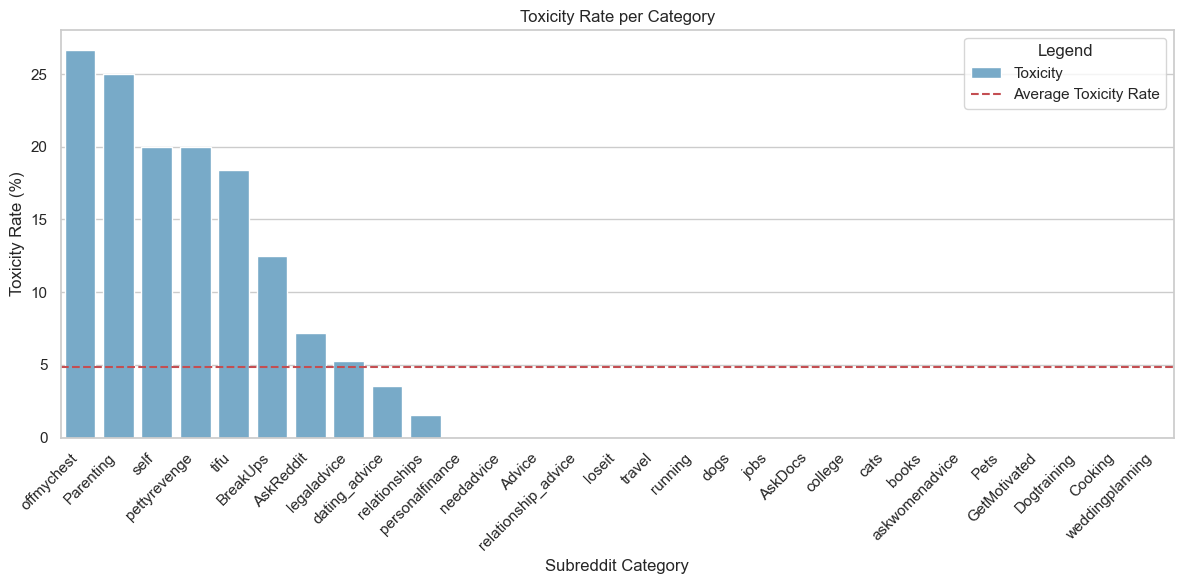

In [136]:
# Plot the Toxicity Rate with the average Toxicity Rate

toxicity_rates = toxicity_analysis_df.groupby('subreddit_category')['toxicity_label'].mean().reset_index()
toxicity_rates['toxicity_rate'] = toxicity_rates['toxicity_label'] * 100

toxicity_rates = toxicity_rates.sort_values(by='toxicity_rate', ascending=False)

plt.figure(figsize=(12, 6))

dark_blue_palette = sns.color_palette("Blues", n_colors=1)

toxicity_rates['hue'] = 'Toxicity'

barplot = sns.barplot(x='subreddit_category', y='toxicity_rate', 
                      data=toxicity_rates, 
                      hue='hue', 
                      palette=dark_blue_palette, 
                      dodge=False)

plt.axhline(y=toxicity_rates['toxicity_rate'].mean(), color='r', linestyle='--', label='Average Toxicity Rate')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Subreddit Category')
plt.ylabel('Toxicity Rate (%)')
plt.title('Toxicity Rate per Category')
plt.legend(title='Legend', loc='upper right')
plt.tight_layout()
plt.show()


In [137]:
def bootstrap_toxicity(df, toxic_categories, n_iterations=1000):
    results = {}
    
    for category in toxic_categories:
        rates = []
        for _ in range(n_iterations):
            sample = df[df['subreddit_category'] == category].sample(frac=1, replace=True)
            rates.append(sample['toxicity_label'].mean())
        results[category] = {
            'mean_tox_rate': np.mean(rates),
            'lower_ci': np.percentile(rates, 2.5),
            'upper_ci': np.percentile(rates, 97.5)
        }

    return pd.DataFrame(results).T

toxic_categories = toxicity_analysis_df.groupby('subreddit_category')['toxicity_label'].sum()
toxic_categories = toxic_categories[toxic_categories > 0].index

bootstrapped_results_toxic = bootstrap_toxicity(toxicity_analysis_df, toxic_categories)
bootstrapped_results_toxic['toxicity_rate_percent'] = bootstrapped_results_toxic['mean_tox_rate'] * 100

bootstrapped_results_toxic


,mean_tox_rate,lower_ci,upper_ci,toxicity_rate_percent
AskReddit,0.071732,0.032680,0.117647,7.173203
BreakUps,0.130000,0.000000,0.375000,13.000000
Parenting,0.242000,0.000000,0.750000,24.200000
dating_advice,0.034429,0.000000,0.107143,3.442857
legaladvice,0.053474,0.000000,0.157895,5.347368
offmychest,0.267400,0.066667,0.466667,26.740000
pettyrevenge,0.196800,0.000000,0.600000,19.680000
relationships,0.016082,0.006329,0.025316,1.608228
self,0.200300,0.000000,0.500000,20.030000
tifu,0.185368,0.105263,0.276316,18.536842


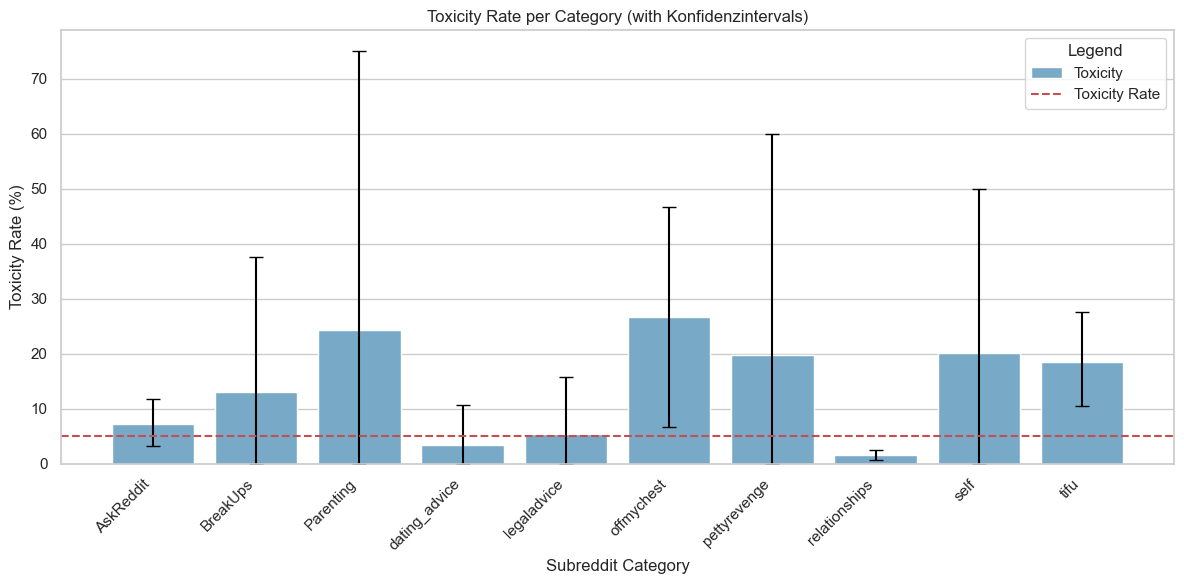

In [138]:
plt.figure(figsize=(12, 6))

bootstrapped_results_toxic['hue'] = 'Toxicity'

barplot = sns.barplot(x=bootstrapped_results_toxic.index, 
                      y='toxicity_rate_percent', 
                      hue='hue',  
                      data=bootstrapped_results_toxic.reset_index(), 
                      palette='Blues',  
                      errorbar=None)

for index, row in bootstrapped_results_toxic.iterrows():
    lower_error = (row['mean_tox_rate'] - row['lower_ci']) * 100
    upper_error = (row['upper_ci'] - row['mean_tox_rate']) * 100
    
    plt.errorbar(x=index, 
                 y=row['toxicity_rate_percent'], 
                 yerr=[[lower_error], [upper_error]], 
                 fmt='none', 
                 c='black', 
                 capsize=5)

plt.axhline(y=5, color='r', linestyle='--', label='Toxicity Rate')
plt.xticks(ticks=np.arange(len(bootstrapped_results_toxic.index)), 
           labels=bootstrapped_results_toxic.index, 
           rotation=45, ha='right')  
plt.xlabel('Subreddit Category')
plt.ylabel('Toxicity Rate (%)')
plt.title('Toxicity Rate per Category (with Konfidenzintervals)')
plt.legend(title='Legend', loc='upper right')
plt.tight_layout()
plt.show()

For the categories "BreakUps", "Parenting", "Petty Revenge", "Self", and "Tifu", there are some zero values in the lower confidence interval. This suggests that toxicity rates in these categories may vary widely. For example, the actual toxicity for "Parenting" could be anywhere between 0% and 75%.
The confidence interval for "AskReddit" is relatively narrow, indicating that the estimate for this category is relatively stable.
The Relationships category has the lowest estimated toxicity rate of 1.59%, indicating that this category contains less toxic content.

In [139]:
# Calculate the difference between upper and lower confidence intervals
bootstrapped_results_toxic['ci_difference'] = bootstrapped_results_toxic['upper_ci'] - bootstrapped_results_toxic['lower_ci']

# Sort by the CI difference
sorted_df = bootstrapped_results_toxic.sort_values(by='ci_difference')
sorted_df = sorted_df.drop(columns=['hue'])

sorted_df

,mean_tox_rate,lower_ci,upper_ci,toxicity_rate_percent,ci_difference
relationships,0.016082,0.006329,0.025316,1.608228,0.018987
AskReddit,0.071732,0.032680,0.117647,7.173203,0.084967
dating_advice,0.034429,0.000000,0.107143,3.442857,0.107143
legaladvice,0.053474,0.000000,0.157895,5.347368,0.157895
tifu,0.185368,0.105263,0.276316,18.536842,0.171053
BreakUps,0.130000,0.000000,0.375000,13.000000,0.375000
offmychest,0.267400,0.066667,0.466667,26.740000,0.400000
self,0.200300,0.000000,0.500000,20.030000,0.500000
pettyrevenge,0.196800,0.000000,0.600000,19.680000,0.600000
Parenting,0.242000,0.000000,0.750000,24.200000,0.750000


In [140]:
narrow_ci_df = sorted_df[sorted_df['ci_difference'] < 0.1]
narrow_ci_df

,mean_tox_rate,lower_ci,upper_ci,toxicity_rate_percent,ci_difference
relationships,0.016082,0.006329,0.025316,1.608228,0.018987
AskReddit,0.071732,0.032680,0.117647,7.173203,0.084967


Now we can say for sure that relationships and AskReddit are the most toxic categories in our Dataset.

## Chi Sqared Test: Test if the difference between the Categories is significant

In [141]:
# Build a Contingency Table

# Group by subreddit_category and toxicity_label and count the number of posts
contingency_table = toxicity_analysis_df.groupby(['subreddit_category', 'toxicity_label']).size().unstack(fill_value=0)

# rename columns for better readability
contingency_table.columns = ['Non-Toxic', 'Toxic']

contingency_table

,Non-Toxic,Toxic
subreddit_category,,
Advice,20,0
AskDocs,2,0
AskReddit,142,11
BreakUps,7,1
Cooking,1,0
Dogtraining,3,0
GetMotivated,1,0
Parenting,3,1
Pets,3,0


In [142]:
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square-Value: {chi2}")
print(f"p-value: {p}")

Chi-Square-Value: 99.30353307800716
p-value: 6.56619249180234e-10


A high chi-squared value (as in your case 99.30) indicates that there is a large deviation between the observed and expected frequencies. This indicates that the distribution of toxicity in the different subreddit categories is not random. <br>
A p-value of 6.56619249180234e-10 is extremely low, indicating that it is very likely that the differences between the categories are significant. Typically, a p-value below 0.05 is considered significant, so the result is very significant. <br>
Because the p-value is so low, we can say with high confidence that there are significant differences in toxicity between the different subreddit categories. This means that certain categories contain more toxic content than others. <br> This rejects our Null-Hypothesis and supports our Hypothesis. <br>
--> There are significant differences in toxicity between the different subreddit categories.

# Hypothesis: Longer posts are more likely to be non-toxic compared to shorter posts.
# Null-Hypothesis: There is no difference in the mean word count between toxic posts and non-toxic posts

## First Impressions

In [143]:
toxicity_analysis_df

,subreddit_category,word_count,preprocessed,toxicity_label
0,Advice,228,"i 'm 23 , moved back in with parents . how do ...",0
1,Advice,143,always feel an overwhelming lack of confidence...,0
2,Advice,233,"dealing with this break up hey there , this mo...",0
3,Advice,398,disagreement when picking rooms in the new hou...,0
4,Advice,226,i do n't know what i believe i do n't typicall...,0
...,...,...,...,...
1144,travel,213,"traveling , a few questions , ( planning a tri...",0
1145,weddingplanning,280,"wedding blanket ? i 'm a plus size bride , wit...",0
1146,weddingplanning,336,"36 days to go , & i ca n't find my english bir...",0
1147,weddingplanning,301,making your own wedding invitations ... is it ...,0


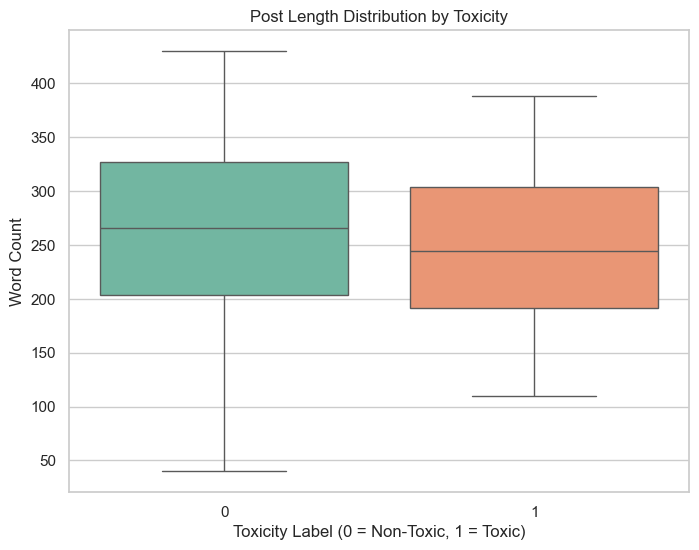

In [144]:
sns.set(style="whitegrid")

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='toxicity_label', y='word_count', data=toxicity_analysis_df, hue='toxicity_label', palette='Set2', legend=False)
plt.title('Post Length Distribution by Toxicity')
plt.xlabel('Toxicity Label (0 = Non-Toxic, 1 = Toxic)')
plt.ylabel('Word Count')
plt.show()

Non-Toxic Posts: <br>
The median word count is slightly above 250 words.
The IQR shows that the bulk of non-toxic posts are between approx. 200 and 300 words.
The range extends from about 50 to over 400 words, meaning there is some variation in post length.
<br>
<br>

Toxic Posts:
The median word count for toxic posts is also around 250 words, similar to non-toxic posts.
The IQR for toxic posts is wider, indicating more variability in the lengths of toxic posts.
Toxic posts range from around 50 to over 400 words, similar to non-toxic posts.
<br>

Median Comparison: Both toxic and non-toxic posts have similar median word counts, so the central tendency of the word count doesn't seem to differ much between the two groups.
<br>
Variability: Toxic posts have a wider range and a slightly larger spread (IQR), meaning there's more variability in post length among toxic posts compared to non-toxic ones.

## Inspect whether the data follow a normal distribution

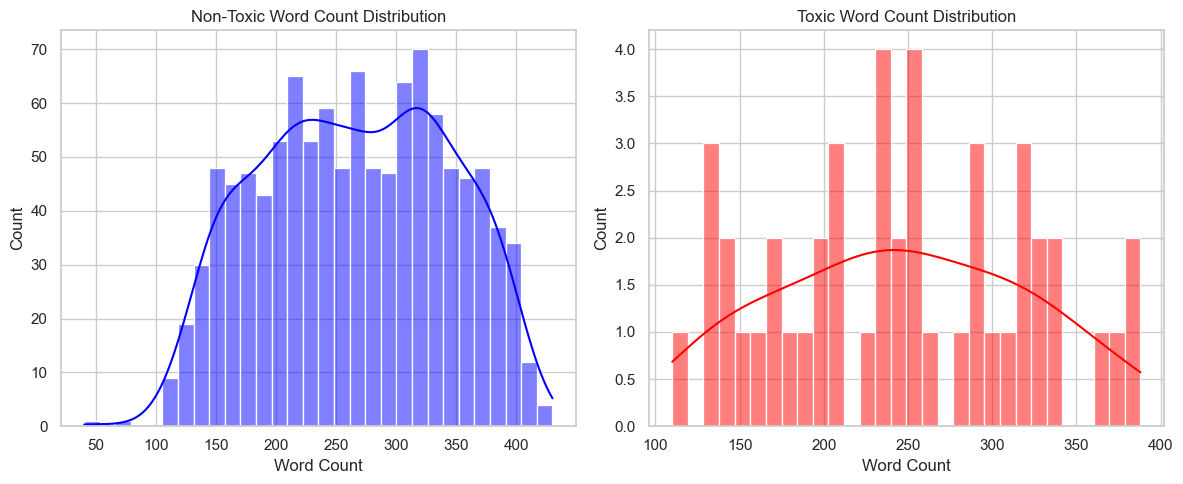

In [145]:
# Separate the data into toxic and non-toxic groups
non_toxic = toxicity_analysis_df[toxicity_analysis_df['toxicity_label'] == 0]['word_count']
toxic = toxicity_analysis_df[toxicity_analysis_df['toxicity_label'] == 1]['word_count']

# Check Normality
# Histogram
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(non_toxic, kde=True, color='blue', bins=30)
plt.title('Non-Toxic Word Count Distribution')
plt.xlabel('Word Count')
plt.subplot(1, 2, 2)
sns.histplot(toxic, kde=True, color='red', bins=30)
plt.title('Toxic Word Count Distribution')
plt.xlabel('Word Count')
plt.tight_layout()
plt.show()

After these plots we could assume that the Non-Toxic Posts are not normally distributed.

#### Shapiro-Wilk Test: Provides a statistical test for normality for each group.

In [146]:
shapiro_non_toxic = stats.shapiro(non_toxic)
shapiro_toxic = stats.shapiro(toxic)
print(f"Shapiro-Wilk Test for Non-Toxic: Statistic={shapiro_non_toxic.statistic}, p-value={shapiro_non_toxic.pvalue}")
print(f"Shapiro-Wilk Test for Toxic: Statistic={shapiro_toxic.statistic}, p-value={shapiro_toxic.pvalue}")

# Interpretation of Shapiro-Wilk results
if shapiro_non_toxic.pvalue < 0.05:
    print("Non-Toxic Posts: Distribution is not normally distributed.")
else:
    print("Non-Toxic Posts: Distribution is normally distributed.")

if shapiro_toxic.pvalue > 0.05:
    print("Toxic Posts: Distribution can be considered normally distributed.")
else:
    print("Toxic Posts: Distribution is not normally distributed.")

Shapiro-Wilk Test for Non-Toxic: Statistic=0.975122332572937, p-value=7.924576251282234e-13
Shapiro-Wilk Test for Toxic: Statistic=0.9728415608406067, p-value=0.3517760932445526
Non-Toxic Posts: Distribution is not normally distributed.
Toxic Posts: Distribution can be considered normally distributed.


### Transformations (for dealing with normality issues) and Further Analysis

#### Log transformation

In [148]:
# try log transformation for dealing with normality
toxicity_analysis_df['log_word_count'] = np.log(toxicity_analysis_df['word_count'] + 1)  # +1 to avoid log(0)

In [149]:
toxicity_analysis_df.head()

,subreddit_category,word_count,preprocessed,toxicity_label,log_word_count
0,Advice,228,"i 'm 23 , moved back in with parents . how do ...",0,5.433722
1,Advice,143,always feel an overwhelming lack of confidence...,0,4.969813
2,Advice,233,"dealing with this break up hey there , this mo...",0,5.455321
3,Advice,398,disagreement when picking rooms in the new hou...,0,5.988961
4,Advice,226,i do n't know what i believe i do n't typicall...,0,5.424950


In [150]:
# Separate the log-transformed data into toxic and non-toxic groups
non_toxic_log = toxicity_analysis_df[toxicity_analysis_df['toxicity_label'] == 0]['log_word_count']
toxic_log = toxicity_analysis_df[toxicity_analysis_df['toxicity_label'] == 1]['log_word_count']

In [151]:
shapiro_non_toxic_log = stats.shapiro(non_toxic_log)
shapiro_toxic_log = stats.shapiro(toxic_log)
print(f"Shapiro-Wilk Test for Non-Toxic: Statistic={shapiro_non_toxic_log.statistic}, p-value={shapiro_non_toxic_log.pvalue}")
print(f"Shapiro-Wilk Test for Toxic: Statistic={shapiro_toxic_log.statistic}, p-value={shapiro_toxic_log.pvalue}")

# Interpretation of Shapiro-Wilk results
if shapiro_non_toxic_log.pvalue < 0.05:
    print("Non-Toxic Posts: Distribution is not normally distributed.")
else:
    print("Non-Toxic Posts: Distribution is normally distributed.")

if shapiro_toxic_log.pvalue > 0.05:
    print("Toxic Posts: Distribution can be considered normally distributed.")
else:
    print("Toxic Posts: Distribution is not normally distributed.")

Shapiro-Wilk Test for Non-Toxic: Statistic=0.952343225479126, p-value=1.926310293167817e-18
Shapiro-Wilk Test for Toxic: Statistic=0.9569194912910461, p-value=0.08697144687175751
Non-Toxic Posts: Distribution is not normally distributed.
Toxic Posts: Distribution can be considered normally distributed.


Non-Toxic Posts:<br>The p-value < 0.05, indicating that the distribution of word counts for non-toxic posts is not normally distributed.
Toxic Posts:<br>The p-value > 0.05, indicating that the distribution of word counts for toxic posts can be considered normally distributed.

#### Square Root Transformation

In [152]:
toxicity_analysis_df['sqrt_word_count'] = np.sqrt(toxicity_analysis_df['word_count'])
# Separate the log-transformed data into toxic and non-toxic groups
non_toxic_sqr = toxicity_analysis_df[toxicity_analysis_df['toxicity_label'] == 0]['sqrt_word_count']
toxic_sqr = toxicity_analysis_df[toxicity_analysis_df['toxicity_label'] == 1]['sqrt_word_count']

In [153]:
shapiro_non_toxic_sqr = stats.shapiro(non_toxic_sqr)
shapiro_toxic_sqr = stats.shapiro(toxic_sqr)
print(f"Shapiro-Wilk Test for Non-Toxic: Statistic={shapiro_non_toxic_sqr.statistic}, p-value={shapiro_non_toxic_sqr.pvalue}")
print(f"Shapiro-Wilk Test for Toxic: Statistic={shapiro_toxic_sqr.statistic}, p-value={shapiro_toxic_sqr.pvalue}")

# Interpretation of Shapiro-Wilk results
if shapiro_non_toxic_sqr.pvalue < 0.05:
    print("Non-Toxic Posts: Distribution is not normally distributed.")
else:
    print("Non-Toxic Posts: Distribution is normally distributed.")

if shapiro_toxic_sqr.pvalue > 0.05:
    print("Toxic Posts: Distribution can be considered normally distributed.")
else:
    print("Toxic Posts: Distribution is not normally distributed.")

Shapiro-Wilk Test for Non-Toxic: Statistic=0.9709317088127136, p-value=4.530777540797358e-14
Shapiro-Wilk Test for Toxic: Statistic=0.9704659581184387, p-value=0.2882581651210785
Non-Toxic Posts: Distribution is not normally distributed.
Toxic Posts: Distribution can be considered normally distributed.


#### Box-Cox Transformation


Box-Cox Transformed Data:
Non-Toxic Shapiro-Wilk: Statistic=0.9751917719841003, p-value=8.331277833416306e-13
Toxic Shapiro-Wilk: Statistic=0.973059356212616, p-value=0.3581361770629883
Non-Toxic Posts: Distribution is not normally distributed.
Toxic Posts: Distribution can be considered normally distributed.


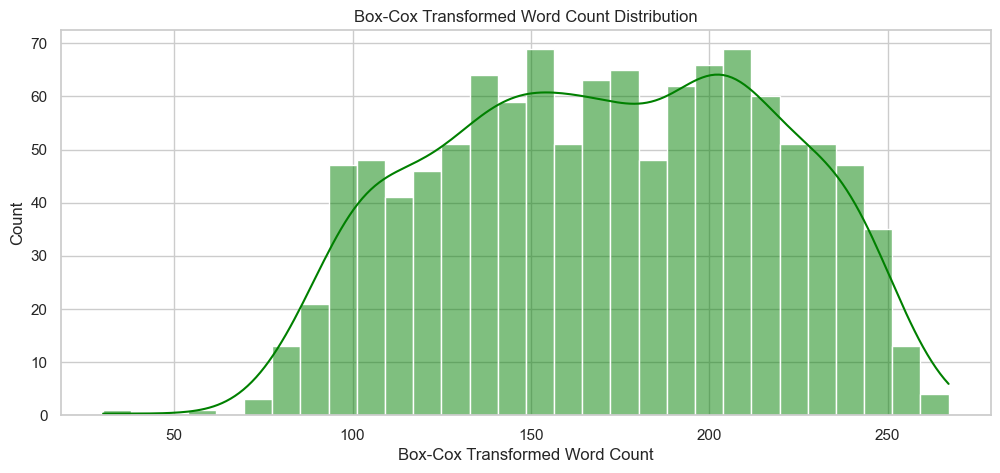

In [161]:
non_toxic_boxcox, _ = boxcox(non_toxic + 1)  # Add 1 to avoid log(0) issues
toxic_boxcox, _ = boxcox(toxic + 1)

# Checking Normality with Shapiro-Wilk Test
shapiro_boxcox_non_toxic = stats.shapiro(non_toxic_boxcox)
shapiro_boxcox_toxic = stats.shapiro(toxic_boxcox)
print("\nBox-Cox Transformed Data:")

print(f"Non-Toxic Shapiro-Wilk: Statistic={shapiro_boxcox_non_toxic.statistic}, p-value={shapiro_boxcox_non_toxic.pvalue}")
print(f"Toxic Shapiro-Wilk: Statistic={shapiro_boxcox_toxic.statistic}, p-value={shapiro_boxcox_toxic.pvalue}")


# Interpretation of Shapiro-Wilk results
if shapiro_boxcox_non_toxic.pvalue < 0.05:
    print("Non-Toxic Posts: Distribution is not normally distributed.")
else:
    print("Non-Toxic Posts: Distribution is normally distributed.")

if shapiro_boxcox_toxic.pvalue > 0.05:
    print("Toxic Posts: Distribution can be considered normally distributed.")
else:
    print("Toxic Posts: Distribution is not normally distributed.")

# Histogram for Box-Cox transformed data
plt.figure(figsize=(12, 5))
sns.histplot(toxicity_analysis_df['boxcox_word_count'], kde=True, color='green', bins=30)
plt.title('Box-Cox Transformed Word Count Distribution')
plt.xlabel('Box-Cox Transformed Word Count')
plt.show()

Yeo-Johnson Transformed Data:
Non-Toxic Shapiro-Wilk: Statistic=0.9751917719841003, p-value=8.331277833416306e-13
Toxic Shapiro-Wilk: Statistic=0.973059356212616, p-value=0.3581361770629883
Non-Toxic Posts: Distribution is not normally distributed.
Toxic Posts: Distribution can be considered normally distributed.


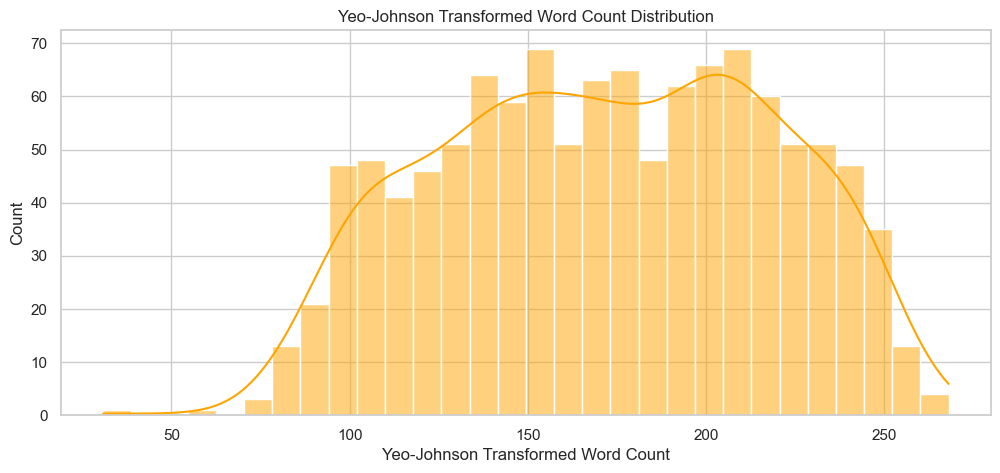

In [163]:
# Checking Normality with Shapiro-Wilk Test

# Yeo-Johnson Transformation
non_toxic_yj, _ = yeojohnson(non_toxic)
toxic_yj, _ = yeojohnson(toxic)

shapiro_yeojohnson_non_toxic = stats.shapiro(non_toxic_yj)
shapiro_yeojohnson_toxic = stats.shapiro(toxic_yj)

print("Yeo-Johnson Transformed Data:")
print(f"Non-Toxic Shapiro-Wilk: Statistic={shapiro_yeojohnson_non_toxic.statistic}, p-value={shapiro_yeojohnson_non_toxic.pvalue}")
print(f"Toxic Shapiro-Wilk: Statistic={shapiro_yeojohnson_toxic.statistic}, p-value={shapiro_yeojohnson_toxic.pvalue}")

# Interpretation of Shapiro-Wilk results
if shapiro_yeojohnson_non_toxic.pvalue < 0.05:
    print("Non-Toxic Posts: Distribution is not normally distributed.")
else:
    print("Non-Toxic Posts: Distribution is normally distributed.")

if shapiro_yeojohnson_toxic.pvalue > 0.05:
    print("Toxic Posts: Distribution can be considered normally distributed.")
else:
    print("Toxic Posts: Distribution is not normally distributed.")

# Histogram for Yeo-Johnson transformed data
plt.figure(figsize=(12, 5))
sns.histplot(toxicity_analysis_df['yeojohnson_word_count'], kde=True, color='orange', bins=30)
plt.title('Yeo-Johnson Transformed Word Count Distribution')
plt.xlabel('Yeo-Johnson Transformed Word Count')
plt.show()


In [156]:
# Perform the Mann-Whitney U test
u_stat, p_value_mann_whitney = stats.mannwhitneyu(non_toxic, toxic)

# Print the results
print(f"Mann-Whitney U statistic: {u_stat}, P-value: {p_value_mann_whitney}")

Mann-Whitney U statistic: 28956.5, P-value: 0.10379810814167889


## Check Homogeneity of Variance

In [169]:
# Original Data:
levene_stat, levene_p = stats.levene(non_toxic, toxic)
print(f"Levene’s Test Statistic: {levene_stat}, p-value: {levene_p}")

# Do the t-test only if assumptions are met, otherwise perform welch t-test
if shapiro_non_toxic.pvalue > 0.05 and shapiro_toxic.pvalue > 0.05 and levene_p > 0.05:
    t_stat, p_value = stats.ttest_ind(non_toxic, toxic, equal_var=True)
    print(f"t-test statistic: {t_stat}, P-value: {p_value}")
else:
    print("Assumptions for t-test are not met. Use Welch's t-test instead.")
    t_stat_welch, p_value_welch = stats.ttest_ind(non_toxic, toxic, equal_var=False)
    print(f"Welch's t-test statistic: {t_stat_welch}, P-value: {p_value_welch}")

# Boxcox Transformed Data:
levene_stat_bc, levene_p_bc = stats.levene(non_toxic_boxcox, toxic_boxcox)
# Perform t-test or Welch's t-test on Box-Cox Transformed Data
if (shapiro_boxcox_non_toxic.pvalue > 0.05 and 
    shapiro_boxcox_toxic.pvalue > 0.05 and 
    levene_p_bc > 0.05):
    t_stat_bc, p_value_bc = stats.ttest_ind(non_toxic_boxcox, toxic_boxcox, equal_var=True)
    print(f"t-test statistic (Box-Cox): {t_stat_bc}, P-value: {p_value_bc}")
else:
    print("Assumptions for t-test are not met for Box-Cox Transformed Data. Use Welch's t-test instead.")
    t_stat_welch_bc, p_value_welch_bc = stats.ttest_ind(non_toxic_boxcox, toxic_boxcox, equal_var=False)
    print(f"Welch's t-test statistic (Box-Cox): {t_stat_welch_bc}, P-value: {p_value_welch_bc}")

# Yeo-Johnson Transformed Data
levene_stat_yj, levene_p_yj = stats.levene(non_toxic_yj, toxic_yj)

# Perform t-test or Welch's t-test on Yeo-Johnson Transformed Data
if (shapiro_yeojohnson_non_toxic.pvalue > 0.05 and 
    shapiro_yeojohnson_toxic.pvalue > 0.05 and 
    levene_p_yj > 0.05):
    t_stat_yj, p_value_yj = stats.ttest_ind(non_toxic_yj, toxic_yj, equal_var=True)
    print(f"t-test statistic (Yeo-Johnson): {t_stat_yj}, P-value: {p_value_yj}")
else:
    print("Assumptions for t-test are not met for Yeo-Johnson Transformed Data. Use Welch's t-test instead.")
    t_stat_welch_yj, p_value_welch_yj = stats.ttest_ind(non_toxic_yj, toxic_yj, equal_var=False)
    print(f"Welch's t-test statistic (Yeo-Johnson): {t_stat_welch_yj}, P-value: {p_value_welch_yj}")


Assumptions for t-test are not met for Box-Cox Transformed Data. Use Welch's t-test instead.
Welch's t-test statistic (Box-Cox): 29.680670955893873, P-value: 1.3982864515883443e-41
Levene’s Test Statistic (Yeo-Johnson): 44.84549171894383, p-value: 3.331248455346896e-11
Assumptions for t-test are not met for Yeo-Johnson Transformed Data. Use Welch's t-test instead.
Welch's t-test statistic (Yeo-Johnson): 29.68067095589387, P-value: 1.3982864515883647e-41


## Summary of t-tests or Welch's t-tests

In [166]:
# Summary of Results
print("\nSummary of Results:")
print(f"Original Data Welch's t-test p-value: {p_value_welch}")
print(f"Box-Cox Transformed Welch's t-test p-value: {p_value_welch_bc}")
print(f"Yeo-Johnson Transformed Welch's t-test p-value: {p_value_welch_yj}")

if p_value_welch < 0.05:
    print("Reject the null hypothesis for original data: Significant difference.")
else:
    print("Fail to reject the null hypothesis for original data: No significant difference.")

if p_value_welch_bc < 0.05:
    print("Reject the null hypothesis for Box-Cox transformed data: Significant difference.")
else:
    print("Fail to reject the null hypothesis for Box-Cox transformed data: No significant difference.")

if p_value_welch_yj < 0.05:
    print("Reject the null hypothesis for Yeo-Johnson transformed data: Significant difference.")
else:
    print("Fail to reject the null hypothesis for Yeo-Johnson transformed data: No significant difference.")


Summary of Results:
Original Data Welch's t-test p-value: 0.09328495533999971
Box-Cox Transformed Welch's t-test p-value: 1.3982864515883443e-41
Yeo-Johnson Transformed Welch's t-test p-value: 1.3982864515883647e-41
Fail to reject the null hypothesis for original data: No significant difference.
Reject the null hypothesis for Box-Cox transformed data: Significant difference.
Reject the null hypothesis for Yeo-Johnson transformed data: Significant difference.


Welch’s t-test: Results are highly dependent on the assumptions of normality that were not met for the non-toxic group. <br>
The Mann-Whitney U test is suitable given the non-normality of the non-toxic group. <br>

## Mann-Whitney U test

In [170]:
# Assuming 'non_toxic' and 'toxic' contain your word count data for original data
mann_whitney_stat, mann_whitney_p = stats.mannwhitneyu(non_toxic, toxic)
print(f"Mann-Whitney U statistic: {mann_whitney_stat}, P-value: {mann_whitney_p}")

Mann-Whitney U statistic: 28956.5, P-value: 0.10379810814167889


: 

Both the Mann-Whitney U test and the Welch’s t-test (on original data) indicate no significant difference in word counts between the two groups (p-value > 0.05)
Our Null-HYpothesis fails to be rejected, which means that there is no difference in the mean word count between toxic posts and non-toxic posts.